In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.autograd import Variable
import copy

import numpy as np
import matplotlib.pyplot as plt

from curv_scoring import get_curv_scores_for_net
from utils import full_train

In [2]:
class SubsetTransformDataset(Dataset):
    def __init__(self, dataset, subset_indices, subset_transform=None, default_transform=None):
        """
        Args:
            dataset (Dataset): The original dataset.
            subset_indices (list or range): The indices for the subset to apply the transform.
            subset_transform (callable, optional): A function/transform to apply to the subset.
            default_transform (callable, optional): A function/transform to apply to the entire datset first.
        """
        self.dataset = dataset
        self.subset_indices = subset_indices
        self.subset_transform = subset_transform
        self.default_transform = default_transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        if self.default_transform:
            image = self.default_transform(image)

        # Apply the transform only to the subset
        if idx in self.subset_indices and self.subset_transform:
            image = self.subset_transform(image)

        return image, label


In [3]:
class Pseudoinverse:
    def __call__(self, img):
        """
        Replace the given image with a perturbed image per deepfool attack.
        """
        img = torch.from_numpy(np.linalg.pinv(img.numpy()))
        img = img / torch.max(img)
        # img = transforms.GaussianBlur()

        return img

In [4]:
mnist = torchvision.datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=False)

In [8]:
kmnist = torchvision.datasets.KMNIST(root='./data', train=True, transform=transforms.ToTensor(), download=False)

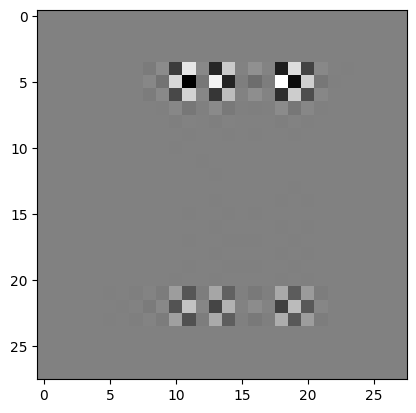

In [10]:
testpinv = SubsetTransformDataset(mnist, torch.arange(10), Pseudoinverse())
plt.imshow(testpinv[0][0].numpy().squeeze(), cmap='gray')

In [5]:
fake_data = torchvision.datasets.FakeData(len(mnist), image_size=(1, 28, 28), num_classes=10, transform=transforms.ToTensor())

In [6]:
class ReplaceWithDataset:
    def __init__(self, replace_dataset):
        """
        Args:
            replace_dataset (Dataset): The dataset to pick images from.
        """
        self.replace_dataset = replace_dataset

    def __call__(self, img):
        """
        Replace the given image with an image from replacement dataset.
        """
        img, _ = self.replace_dataset[np.random.randint(0, len(self.replace_dataset))]

        return img

In [ ]:
sizes = [1, 10, 100, 1000, 10000]

for size in sizes:
    print(f'Size {size}:')
    for i in range(5):
        print(f'Saving scores for run {i+1}...')
        subset_idx = torch.randperm(len(mnist))[:size]
        fake_dataset = SubsetTransformDataset(mnist, subset_idx, ReplaceWithDataset(fake_data))
        net = full_train(fake_dataset)
        scores = get_curv_scores_for_net(fake_dataset, net)
        score_dict = dict(subset=subset_idx, scores=scores)
        np.savez(f'mnist_curv_scores/fakedata_{size}/run_{i+1}', **score_dict)

In [9]:
sizes = [1, 10, 100, 1000, 10000]

for size in sizes:
    print(f'Size {size}:')
    for i in range(5):
        print(f'Saving scores for run {i+1}...')
        subset_idx = torch.randperm(len(mnist))[:size]
        fake_dataset = SubsetTransformDataset(mnist, subset_idx, ReplaceWithDataset(kmnist))
        net = full_train(fake_dataset)
        scores = get_curv_scores_for_net(fake_dataset, net)
        score_dict = dict(subset=subset_idx, scores=scores)
        np.savez(f'mnist_curv_scores/kmnist_{size}/run_{i+1}', **score_dict)

Size 1:
Saving scores for run 1...
Saving scores for run 2...
Saving scores for run 3...
Saving scores for run 4...
Saving scores for run 5...
Size 10:
Saving scores for run 1...
Saving scores for run 2...
Saving scores for run 3...
Saving scores for run 4...
Saving scores for run 5...
Size 100:
Saving scores for run 1...
Saving scores for run 2...
Saving scores for run 3...
Saving scores for run 4...
Saving scores for run 5...
Size 1000:
Saving scores for run 1...
Saving scores for run 2...
Saving scores for run 3...
Saving scores for run 4...
Saving scores for run 5...
Size 10000:
Saving scores for run 1...
Saving scores for run 2...
Saving scores for run 3...
Saving scores for run 4...
Saving scores for run 5...


In [ ]:
sizes = [1, 10, 100, 1000, 10000]

for size in sizes:
    print(f'Size {size}:')
    for i in range(5):
        print(f'Saving scores for run {i+1}...')
        subset_idx = torch.randperm(len(mnist))[:size]
        fake_dataset = SubsetTransformDataset(mnist, subset_idx, Pseudoinverse())
        net = full_train(fake_dataset)
        scores = get_curv_scores_for_net(fake_dataset, net)
        print(scores[:10])
        score_dict = dict(subset=subset_idx, scores=scores)
        np.savez(f'mnist_curv_scores/pinv_{size}/run_{i+1}', **score_dict)

Size 1:
Saving scores for run 1...
tensor([8.6720e-04, 2.0756e-07, 7.9033e-06, 3.9040e-06, 7.0741e-06, 2.7800e-06,
        3.7662e-07, 1.7736e-09, 1.2147e-06, 3.7118e-07])
Saving scores for run 2...
tensor([1.7404e-05, 5.0001e-08, 6.0634e-06, 1.5980e-03, 1.3096e-05, 8.9530e-05,
        6.8716e-04, 2.0577e-07, 1.8706e-04, 8.5063e-07])
Saving scores for run 3...
tensor([2.3726e-04, 1.2967e-08, 1.3745e-06, 2.5289e-06, 2.9861e-05, 3.4528e-06,
        7.7486e-08, 8.1045e-09, 3.9198e-06, 7.2246e-09])
Saving scores for run 4...
tensor([6.2443e-05, 1.5060e-07, 1.3084e-06, 3.1198e-06, 3.0482e-06, 3.1796e-07,
        4.4444e-07, 1.8231e-07, 2.0137e-06, 5.4855e-08])
Saving scores for run 5...
tensor([2.3237e-05, 8.0696e-09, 5.8960e-07, 8.5562e-07, 3.4567e-06, 3.2191e-07,
        4.1473e-07, 7.2525e-08, 5.6542e-07, 5.1798e-08])
Size 10:
Saving scores for run 1...
tensor([3.7061e-05, 1.4702e-08, 9.3176e-07, 4.0280e-06, 1.3783e-05, 1.7400e-06,
        1.2035e-06, 6.2562e-08, 4.8239e-06, 2.2255e-08])